In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import  nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from torchvision import transforms, utils
import skimage.io as skio
from vit_pytorch.efficient import ViT
from linformer import Linformer

device = "cuda" if torch.cuda.is_available() else "cpu"

import einops
def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.show()

def rearrange_tensor(img):
    return einops.rearrange(img, "c w h -> w h c")

def unnormalize_tensor(img):   
    img = img.detach().numpy()
#     img = einops.rearrange(img, "b c w h -> w h (b c)")
    img = einops.rearrange(img, "c w h -> w h c")

    mean = np.array([0.485, 0.456, 0.406])
    std =  np.array([0.229, 0.224, 0.225])
    img = (img * std) + mean
    return img

def unnormalize_img(img):   
    mean = np.array([0.485, 0.456, 0.406])
    std =  np.array([0.229, 0.224, 0.225])
    img = (img * std) + mean
    return img


def normalize_image(img):
    # normalize all images, this is necessary prepreocessing of inputs for vgg network
    normalize = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Resize(256), 
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize((0.485, 0.456, 0.406), 
                                          (0.229, 0.224, 0.225))
                    ])
    img = normalize(img)
#     img = img[:3,:,:].unsqueeze(0)
    return img

In [2]:
device

'cuda'

In [3]:
class ChestDataset(Dataset):
    def __init__(self, class_name = "Pneumonia", val = False):
        _metadata = pd.read_csv("input/data/Data_Entry_2017.csv")
#         _metadata = _metadata.sample(frac = 1)
        metadata_true = _metadata.loc[_metadata["Finding Labels"].str.contains(class_name)]
        metadata_false = _metadata.loc[_metadata["Finding Labels"].str.contains("No Finding")]
        num_train = int(.6 * len(metadata_true))
        num_val = int(.4 * len(metadata_true))
        train_metadata = pd.concat([metadata_true[:num_train], metadata_false[:num_train]])
        val_metadata = pd.concat([metadata_true[num_train:], metadata_false[num_train : num_train + num_val]])
        self.metadata = pd.concat([train_metadata, val_metadata])
        self.num_train = num_train
        self.num_val = num_val
        self.class_name = class_name
        self.data = {}
        self.val = val
    def __len__(self): 
        if not self.val:
            return self.num_train * 2
        return self.num_val * 2
    def __getitem__(self, idx):
        if self.val:
            idx += self.num_train * 2
        if idx in self.data:
            return self.data[idx]
        file_name = self.metadata.iloc[idx]["Image Index"]
        row = self.metadata.iloc[idx].name
        folder_num = 1
        if row >= 4999:
            folder_num = (row - 4999) // 10000 + 2
        image_file_path = "input/data/images_" + str(folder_num).zfill(3) + "/images/" + file_name
        img = skio.imread(image_file_path)
        if len(img.shape) >= 3:
            img = img[:, :, 0]
        label = self.metadata.iloc[idx]["Finding Labels"]
#         print (file_name, self.metadata.iloc[idx].name, label)
        # turn 1-channel image to 3-channel image
        img = np.stack((img,)*3, axis=-1)
        # crop & normalize
        img = normalize_image(img)
        
        if self.class_name in label:
            self.data[idx] = (img, 1)
            return img, 1
        self.data[idx] = (img, 0)
        return img, 0

In [4]:
class MulticlassChestDataset(Dataset):
    def __init__(self, val = False):
        _metadata = pd.read_csv("input/data/Data_Entry_2017.csv")
#         _metadata = _metadata.sample(frac = 1)
        num_train = int(.6 * len(_metadata))
        num_val = int(.4 * len(_metadata))
        self.metadata = _metadata
        self.num_train = num_train
        self.num_val = num_val
        self.data = {}
        self.val = val
        self.classes = {"Atelectasis" : 0, "Cardiomegaly" : 1, "Effusion" : 2, "Infiltration" : 3, "Mass" : 4, "Nodule" : 5, "Pneumonia" : 6, "Pneumothorax" : 7, 
                        "Consolidation" : 8, "Edema" : 9, "Emphysema" : 10, 
                        "Fibrosis" : 11, "Pleural_Thickening" : 12, "Hernia" : 13, "No Finding" : 14}
    def __len__(self): 
        if not self.val:
            return self.num_train
        return self.num_val
    def __getitem__(self, idx):
        if self.val:
            idx += self.num_train
        if idx in self.data:
            return self.data[idx]
        file_name = self.metadata.iloc[idx]["Image Index"]
        row = self.metadata.iloc[idx].name
        folder_num = 1
        if row >= 4999:
            folder_num = (row - 4999) // 10000 + 2
        image_file_path = "input/data/images_" + str(folder_num).zfill(3) + "/images/" + file_name
        img = skio.imread(image_file_path)
        if len(img.shape) >= 3:
            img = img[:, :, 0]
        label = self.metadata.iloc[idx]["Finding Labels"]
        splitted = label.split("|")
        vectorized_label = np.zeros((15, 1), dtype = "double")
        for diagnosis in splitted:
            vectorized_label[self.classes[diagnosis]] = 1.0
#         tensor_label = torch.from_numpy(vectorized_label)
#         tensor_label = tensor_label.unsqueeze(2)
        # turn 1-channel image to 3-channel image
        img = np.stack((img,)*3, axis=-1)
        # crop & normalize
        img = normalize_image(img)
        return img, vectorized_label

In [5]:
class BinaryRelevance(nn.Module):
    def __init__(self, weights):
        super(BinaryRelevance, self).__init__()
        self.models = []
        self.class_names = []
        for class_name in {"Atelectasis" : 0, "Cardiomegaly" : 1, "Effusion" : 2, "Infiltration" : 3, "Mass" : 4, "Nodule" : 5, "Pneumonia" : 6, "Pneumothorax" : 7, 
                    "Consolidation" : 8, "Edema" : 9, "Emphysema" : 10, 
                    "Fibrosis" : 11, "Pleural_Thickening" : 12, "Hernia" : 13}:
            efficient_transformer = Linformer(
                dim=128,
                seq_len=50,  # 7x7 patches + 1 cls-token
                depth=12,
                heads=8,
                k=64
            )
            model = ViT(
                dim=128,
                image_size=224,
                patch_size=32,
                num_classes=2,
                transformer=efficient_transformer,
                channels=3,
            ).to(device)
            model = torch.load(class_name + ".pt")
            model.eval()
            self.models.append(model)
            self.class_names.append(class_name)
        self.weights = weights
    def forward(self, x):
        probs = np.zeros((14,))
        for i, model in enumerate(self.models):
            prob = (model(x)[0][1].cpu().detach().numpy())
            probs[i] = prob
        return probs * self.weights
        

In [26]:
# ensemble = BinaryRelevance(np.array([1] + [0] * 13))
weights = [0] * 14 # 1 2 3 6 8 9
weights[1], weights[2], weights[3], weights[6], weights[8], weights[9] = 2, 1, 1, 1, 1, 1
print (weights)
ensemble = BinaryRelevance(weights)
ensemble

[0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0]


BinaryRelevance()

In [28]:
from einops import rearrange, repeat
def get_latent(vit_model, img):
    x = vit_model.to_patch_embedding(img)
    b, n, _ = x.shape

    cls_tokens = repeat(vit_model.cls_token, '() n d -> b n d', b = b)
    x = torch.cat((cls_tokens, x), dim=1)
    x += vit_model.pos_embedding[:, :(n + 1)]
    x = vit_model.transformer(x)

    x = x.mean(dim = 1) if vit_model.pool == 'mean' else x[:, 0]

    return vit_model.to_latent(x)


In [29]:
embeddings = np.zeros((500, 14))
multilabel_embeddings = np.zeros((500, 128))
multilabel_model = torch.load("Multilabel.pt")
multilabel_model.eval()
embeddings = np.array(embeddings)
imgs = []
labels = []
train_dataset = MulticlassChestDataset()
train_dataloader = DataLoader(train_dataset, num_workers = 4)
for idx, sample in enumerate(tqdm(train_dataloader)):
    if idx >= 499: break
    img, label = sample
    labels.append(label.numpy())
    img = img.to(device)
    multi_embedding = get_latent(multilabel_model, img)
    multilabel_embeddings[idx] = (multi_embedding.cpu().detach().numpy())
    original_image = unnormalize_img(einops.rearrange(img.cpu().detach().numpy(), "b c w h -> w h (b c)"))
    imgs.append(original_image)
    embeddings[idx] = ensemble(img)
    


  0%|          | 0/67272 [00:00<?, ?it/s]

In [30]:
embeddings = np.array(embeddings)

from sklearn.manifold import TSNE

# The default of 1,000 iterations gives fine results, but I'm training for longer just to eke
# out some marginal improvements. NB: This takes almost an hour!
tsne = TSNE()

low_dim_embeddings = tsne.fit_transform(embeddings)

/home/cjayasur/anaconda3/envs/cuda1.3-gpu/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/cjayasur/anaconda3/envs/cuda1.3-gpu/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


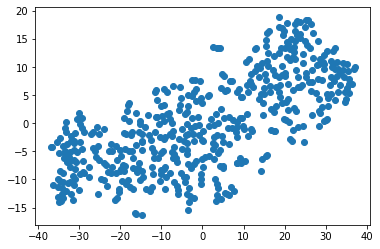

In [31]:
plt.scatter(low_dim_embeddings[:, 0], low_dim_embeddings[:, 1])

In [32]:
from numpy import random
from scipy.spatial import distance

def closest_node(node, nodes):
    return np.argsort(distance.cdist(node, nodes))[:, :5][0]

In [33]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

def image_grid(img_arr):
    fig = plt.figure(figsize=(20., 20.))
    grid = ImageGrid(fig, 111, 
                     nrows_ncols=(1, 5),  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes
                     )

    for ax, im in zip(grid, img_arr):
        ax.imshow(im)

    plt.show()

In [34]:
validation_dataset = MulticlassChestDataset(val = True)

QUERY IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0', dtype=torch.float64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


BINARY RELEVANCE CLOSEST IMAGES:
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


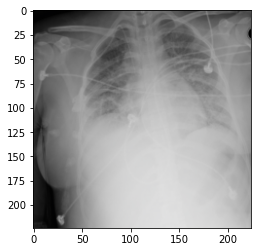

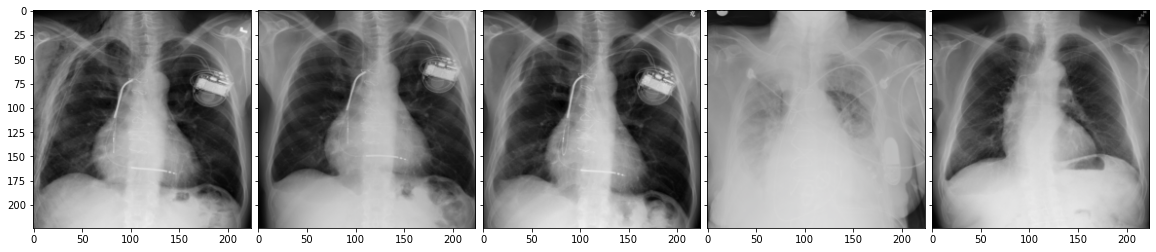

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MULTILABEL CLOSEST IMAGES:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


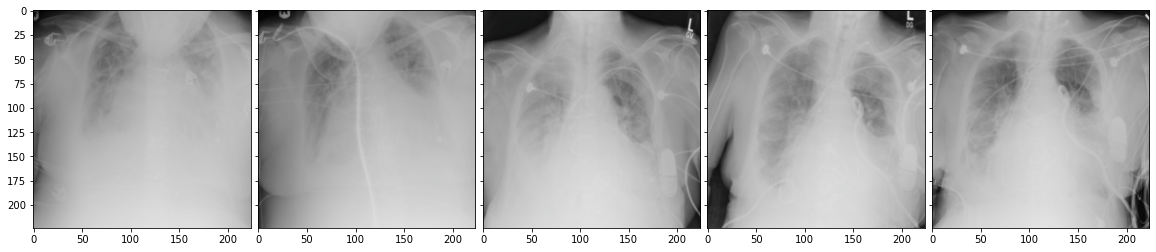

In [38]:
print ("QUERY IMAGE")
query_data_loader = DataLoader(validation_dataset, num_workers = 4, shuffle = True)
for sample in query_data_loader:
    img, label = sample
    original_image = unnormalize_img(einops.rearrange(img.numpy(), "b c w h -> w h (b c)"))
    plt.imshow(original_image)
    img = img.to(device)
    label = label.to(device)
    print (label.reshape(1, 15))
    embedding = ensemble(img)
    multilabel_embedding = get_latent(multilabel_model, img).cpu().detach().numpy()
    break
embedding = embedding.reshape((1, 14))
indices = closest_node(embedding, embeddings)
top_images = np.array(imgs)[indices]

multi_indices = closest_node(multilabel_embedding, multilabel_embeddings)
multi_top_images = np.array(imgs)[multi_indices]



print("BINARY RELEVANCE CLOSEST IMAGES:")
for i in (np.array(labels)[indices]):
    print ((i[0].reshape((1,15)))[0])
image_grid(top_images)

print("MULTILABEL CLOSEST IMAGES:")
for i in (np.array(labels)[multi_indices]):
    print ((i[0].reshape((1,15)))[0])
image_grid(multi_top_images)